# CIFAR10 Image Classification

Fast-forward to 2012, and we move on to the deeper and more modern AlexNet architecture. We will use the CIFAR10 dataset that uses 60,000 ImageNet samples, compressed to 32x32 pixel resolution (from the original 224x224), but still with three color channels. There are only 10 of the original 1,000 classes. 

## Imports

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
results_path = Path('results', 'cifar10')
if not results_path.exists():
    results_path.mkdir()

## Load CIFAR-10 Data

CIFAR10 can also be downloaded from keras, and we similarly rescale the pixel values and one-hot encode the ten class labels. 

In [5]:
# load the pre-shuffled train and test data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

### Visualize the First 30 Training Images

In [6]:
cifar10_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

In [7]:
num_classes = len(cifar10_labels)

In [8]:
height, width, channels = X_train.shape[1:]
input_shape = height, width, channels
input_shape

(32, 32, 3)

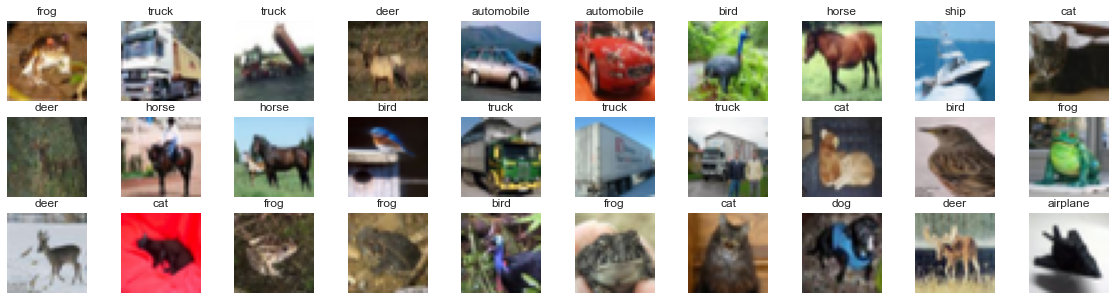

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(np.squeeze(X_train[i]))
    ax.axis('off')
    ax.set_title(cifar10_labels[y_train[i, 0]])

### Rescale the Images

In [10]:
# rescale [0,255] --> [0,1]
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

### Train-Test split

In [11]:
X_train, X_valid = X_train[5000:], X_train[:5000]
y_train, y_valid = y_train[5000:], y_train[:5000]

In [12]:
# shape of training set
X_train.shape

(45000, 32, 32, 3)

In [13]:
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_valid.shape[0], 'validation samples')

45000 train samples
10000 test samples
5000 validation samples


## Feedforward Neural Network

We first train a two-layer feedforward network on 50,000 training samples for training for 20 epochs to achieve a test accuracy of 44.22%. We also experiment with a three-layer convolutional net with 500K parameters for 67.07% test accuracy.

### Model Architecture 

In [14]:
mlp = Sequential([
    Flatten(input_shape=input_shape, name='input'),
    Dense(1000, activation='relu', name='hidden_layer_1'),
    Dropout(0.2, name='droput_1'),
    Dense(512, activation='relu', name='hidden_layer_2'),
    Dropout(0.2, name='dropout_2'),
    Dense(num_classes, activation='softmax', name='output')
])

In [15]:
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 1000)              3073000   
_________________________________________________________________
droput_1 (Dropout)           (None, 1000)              0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 512)               512512    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
output (Dense)               (None, 10)                5130      
Total params: 3,590,642
Trainable params: 3,590,642
Non-trainable params: 0
______________________________________________

### Compile the Model 

In [16]:
mlp.compile(loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

### Define Callbacks

In [17]:
mlp_path = (results_path / 'mlp.weights.best.hdf5').as_posix()

In [18]:
checkpointer = ModelCheckpoint(filepath=mlp_path,
                               verbose=1,
                               monitor='val_accuracy',
                               save_best_only=True)

In [19]:
tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'mlp',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

In [20]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

### Train the Model 

In [21]:
batch_size = 32
epochs = 100

In [22]:
mlp_history = mlp.fit(X_train,
                      y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_valid, y_valid),
                      callbacks=[checkpointer, tensorboard, early_stopping],
                      verbose=1,
                      shuffle=True)

Epoch 1/100
1402/1407 [============================>.] - ETA: 0s - loss: 1.9862 - accuracy: 0.2738
Epoch 00001: val_accuracy improved from -inf to 0.34060, saving model to results/cifar10/mlp.weights.best.hdf5
1407/1407 [==============================] - 6s 4ms/step - loss: 1.9860 - accuracy: 0.2737 - val_loss: 1.8299 - val_accuracy: 0.3406
Epoch 2/100
1396/1407 [============================>.] - ETA: 0s - loss: 1.8507 - accuracy: 0.3252
Epoch 00002: val_accuracy improved from 0.34060 to 0.36960, saving model to results/cifar10/mlp.weights.best.hdf5
1407/1407 [==============================] - 6s 4ms/step - loss: 1.8507 - accuracy: 0.3253 - val_loss: 1.7528 - val_accuracy: 0.3696
Epoch 3/100
1396/1407 [============================>.] - ETA: 0s - loss: 1.8112 - accuracy: 0.3431
Epoch 00003: val_accuracy improved from 0.36960 to 0.37920, saving model to results/cifar10/mlp.weights.best.hdf5
1407/1407 [==============================] - 6s 4ms/step - loss: 1.8110 - accuracy: 0.3433 - val_l

Epoch 55/100
1390/1407 [============================>.] - ETA: 0s - loss: 1.5567 - accuracy: 0.4368
Epoch 00055: val_accuracy did not improve from 0.46180
1407/1407 [==============================] - 4s 3ms/step - loss: 1.5565 - accuracy: 0.4370 - val_loss: 1.5689 - val_accuracy: 0.4326
Epoch 56/100
1398/1407 [============================>.] - ETA: 0s - loss: 1.5556 - accuracy: 0.4418
Epoch 00056: val_accuracy did not improve from 0.46180
1407/1407 [==============================] - 4s 3ms/step - loss: 1.5553 - accuracy: 0.4419 - val_loss: 1.5362 - val_accuracy: 0.4574
Epoch 57/100
1400/1407 [============================>.] - ETA: 0s - loss: 1.5509 - accuracy: 0.4421
Epoch 00057: val_accuracy did not improve from 0.46180
1407/1407 [==============================] - 5s 3ms/step - loss: 1.5507 - accuracy: 0.4421 - val_loss: 1.5463 - val_accuracy: 0.4594
Epoch 58/100
1397/1407 [============================>.] - ETA: 0s - loss: 1.5535 - accuracy: 0.4405
Epoch 00058: val_accuracy did not im

### Plot CV Results

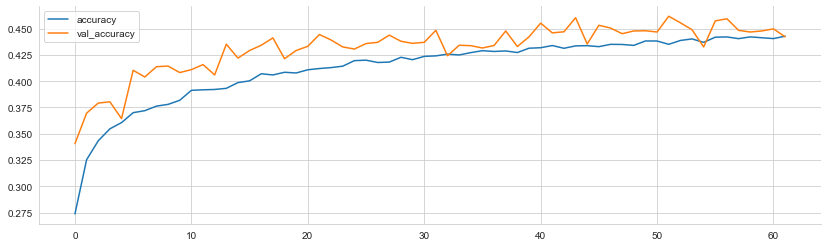

In [23]:
pd.DataFrame(mlp_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(14, 4))
sns.despine()

### Load best model

In [24]:
# load the weights that yielded the best validation accuracy
mlp.load_weights(mlp_path)

### Test Classification Accuracy

In [25]:
# evaluate and print test accuracy
mlp_accuracy = mlp.evaluate(X_test, y_test, verbose=0)[1]
print('Test accuracy: {:.2%}'.format(mlp_accuracy))

Test accuracy: 45.24%


## Convolutional Neural Network

In [26]:
# https://stackoverflow.com/questions/35114376/error-when-computing-summaries-in-tensorflow/35117760#35117760
K.clear_session()

### Model Architecture

In [27]:
cnn = Sequential([
    Conv2D(filters=16,
           kernel_size=2,
           padding='same',
           activation='relu',
           input_shape=input_shape,
           name='CONV1'),
    MaxPooling2D(pool_size=2, name='POOL1'),
    Conv2D(filters=32,
           kernel_size=2,
           padding='same',
           activation='relu',
           name='CONV2'),
    MaxPooling2D(pool_size=2, name='POOL2'),
    Conv2D(filters=64,
           kernel_size=2,
           padding='same',
           activation='relu',
           name='CONV3'),
    MaxPooling2D(pool_size=2, name='POOL3'),
    Dropout(0.3, name='DROP1'),
    Flatten(name='FLAT1'),
    Dense(500, activation='relu', name='FC1'),
    Dropout(0.4, name='DROP2'),
    Dense(10, activation='softmax', name='FC2')
])

In [28]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV1 (Conv2D)               (None, 32, 32, 16)        208       
_________________________________________________________________
POOL1 (MaxPooling2D)         (None, 16, 16, 16)        0         
_________________________________________________________________
CONV2 (Conv2D)               (None, 16, 16, 32)        2080      
_________________________________________________________________
POOL2 (MaxPooling2D)         (None, 8, 8, 32)          0         
_________________________________________________________________
CONV3 (Conv2D)               (None, 8, 8, 64)          8256      
_________________________________________________________________
POOL3 (MaxPooling2D)         (None, 4, 4, 64)          0         
_________________________________________________________________
DROP1 (Dropout)              (None, 4, 4, 64)          0

### Compile the Model

In [29]:
cnn.compile(loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

### Define Callbacks

In [30]:
cnn_path = (results_path / 'cnn.weights.best.hdf5').as_posix()

In [31]:
checkpointer = ModelCheckpoint(filepath=cnn_path,
                               verbose=1,
                               monitor='val_accuracy',
                               save_best_only=True)

In [32]:
tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'cnn',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

In [33]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

### Train the Model

In [34]:
batch_size = 32
epochs = 100

In [35]:
cnn_history = cnn.fit(X_train,
                      y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_valid, y_valid),
                      callbacks=[checkpointer, tensorboard, early_stopping],
                      verbose=2,
                      shuffle=True)

Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.53480, saving model to results/cifar10/cnn.weights.best.hdf5
1407/1407 - 5s - loss: 1.5758 - accuracy: 0.4249 - val_loss: 1.2937 - val_accuracy: 0.5348
Epoch 2/100

Epoch 00002: val_accuracy improved from 0.53480 to 0.60000, saving model to results/cifar10/cnn.weights.best.hdf5
1407/1407 - 4s - loss: 1.2683 - accuracy: 0.5436 - val_loss: 1.1202 - val_accuracy: 0.6000
Epoch 3/100

Epoch 00003: val_accuracy improved from 0.60000 to 0.64120, saving model to results/cifar10/cnn.weights.best.hdf5
1407/1407 - 5s - loss: 1.1385 - accuracy: 0.5918 - val_loss: 1.0183 - val_accuracy: 0.6412
Epoch 4/100

Epoch 00004: val_accuracy improved from 0.64120 to 0.65340, saving model to results/cifar10/cnn.weights.best.hdf5
1407/1407 - 5s - loss: 1.0481 - accuracy: 0.6269 - val_loss: 0.9816 - val_accuracy: 0.6534
Epoch 5/100

Epoch 00005: val_accuracy improved from 0.65340 to 0.68180, saving model to results/cifar10/cnn.weights.best.hdf5
1407

### Plot CV Results

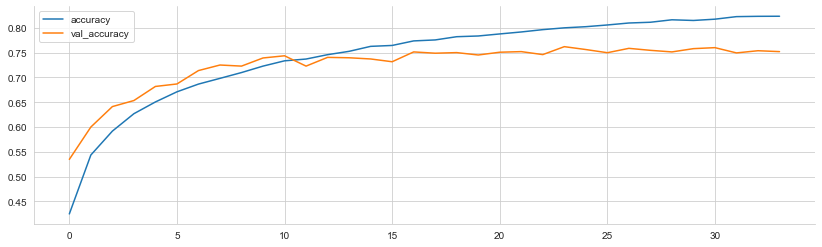

In [36]:
pd.DataFrame(cnn_history.history)[['accuracy',
                                   'val_accuracy']].plot(figsize=(14, 4))
sns.despine();

### Load best model

In [37]:
cnn.load_weights(cnn_path)

### Test set accuracy

In [38]:
cnn_accuracy = cnn.evaluate(X_test, y_test, verbose=0)[1]
print('Accuracy: {:.2%}'.format(cnn_accuracy))

Accuracy: 75.15%


### Evaluate Predictions

In [39]:
y_hat = cnn.predict(X_test)

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t-dl/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 10003 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t-dl/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 10003 missing from current font.
  font.set_text(s, 0, flags=flags)


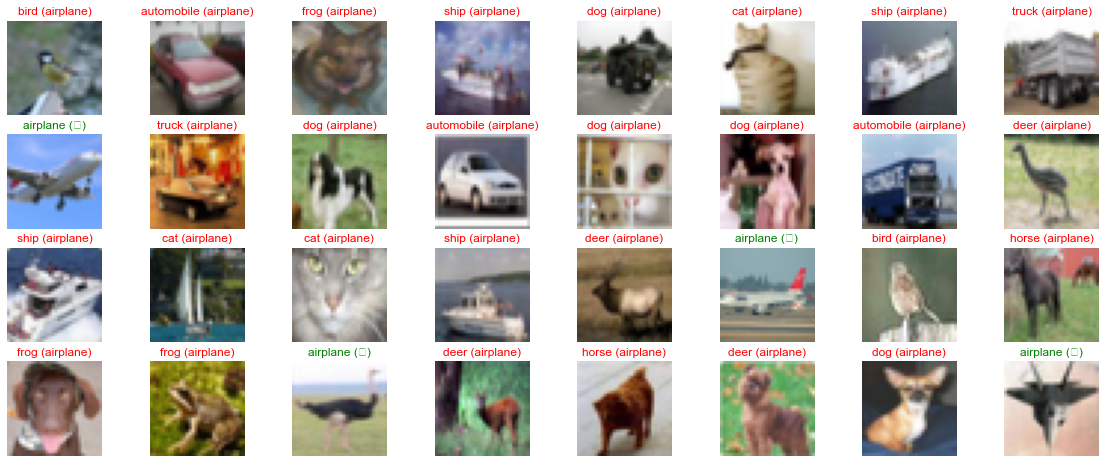

In [40]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20, 8))
axes = axes.flatten()
images = np.random.choice(X_test.shape[0], size=32, replace=False)
for i, (ax, idx) in enumerate(zip(axes, images)):
    ax.imshow(np.squeeze(X_test[idx]))
    ax.axis('off')
    pred_idx, true_idx = np.argmax(y_hat[idx]), np.argmax(y_test[idx])
    if pred_idx == true_idx:
        ax.set_title('{} (✓)'.format(cifar10_labels[pred_idx]), color="green")
    else:
        ax.set_title("{} ({})".format(cifar10_labels[pred_idx],
                                      cifar10_labels[true_idx]),
                     color='red')

## CNN with Image Augmentation

A common trick to enhance performance is to artificially increase the size of the training set by creating synthetic data. This involves randomly shifting or horizontally flipping the image, or introducing noise into the image.

### Create and configure augmented image generator

Keras includes an ImageDataGenerator for this purpose that we can configure and fit to the training data as follows:

In [41]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # randomly horizontal shift
    height_shift_range=0.1,  # randomly vertial shift
    horizontal_flip=True)  # randomly horizontalflip

In [42]:
# fit augmented image generator on data
datagen.fit(X_train)

### Visualize subset of training data

The result shows how the augmented images have been altered in various ways as expected:

In [43]:
n_images = 6
x_train_subset = X_train[:n_images]

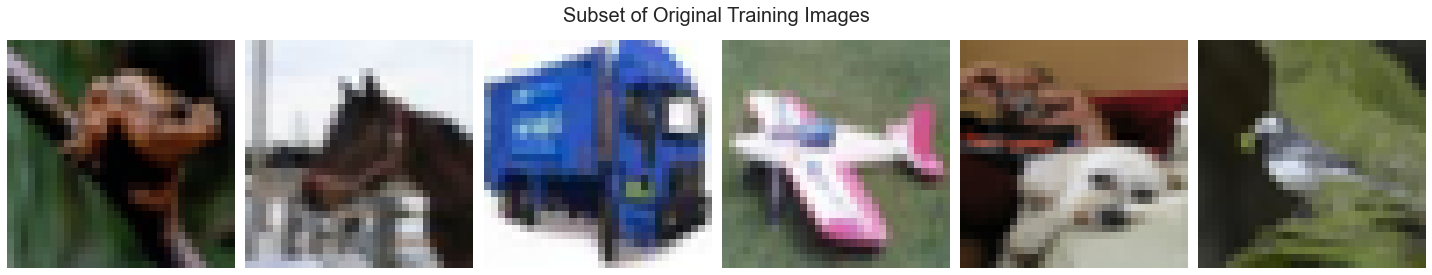

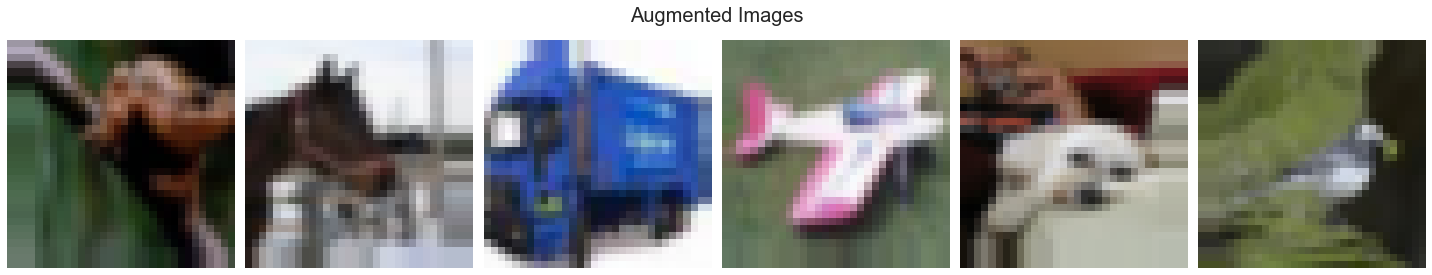

In [44]:
# original images
fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(20, 4))
for i, (ax, img) in enumerate(zip(axes, x_train_subset)):
    ax.imshow(img)
    ax.axis('off')
fig.suptitle('Subset of Original Training Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'original_images')

# augmented images
fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(20, 4))
for x_batch in datagen.flow(x_train_subset, batch_size=n_images,
                            shuffle=False):
    for i, ax in enumerate(axes):
        ax.imshow(x_batch[i])
        ax.axis('off')
#     fig.suptitle('Augmented Images', fontsize=20)
    break
fig.suptitle('Augmented Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'augmented_images')

### Define Callbacks

In [45]:
K.clear_session()

In [46]:
cnn_aug_path = (results_path / 'augmented.cnn.weights.best.hdf5').as_posix()

In [47]:
checkpointer = ModelCheckpoint(filepath=cnn_aug_path,
                               verbose=1,
                               monitor='val_accuracy',
                               save_best_only=True)

In [48]:
tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'cnn_aug',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

In [49]:
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=10)

### Train Augmented Images

In [50]:
batch_size = 32
epochs = 100

In [51]:
cnn_aug_history = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                          steps_per_epoch=X_train.shape[0] // batch_size,
                          epochs=epochs,
                          validation_data=(X_valid, y_valid),
                          callbacks=[checkpointer, tensorboard, early_stopping],
                          verbose=2)

Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.73640, saving model to results/cifar10/augmented.cnn.weights.best.hdf5
1406/1406 - 16s - loss: 0.9741 - accuracy: 0.6619 - val_loss: 0.7585 - val_accuracy: 0.7364
Epoch 2/100

Epoch 00002: val_accuracy improved from 0.73640 to 0.73920, saving model to results/cifar10/augmented.cnn.weights.best.hdf5
1406/1406 - 16s - loss: 0.9427 - accuracy: 0.6703 - val_loss: 0.7555 - val_accuracy: 0.7392
Epoch 3/100

Epoch 00003: val_accuracy improved from 0.73920 to 0.74080, saving model to results/cifar10/augmented.cnn.weights.best.hdf5
1406/1406 - 16s - loss: 0.9212 - accuracy: 0.6783 - val_loss: 0.7572 - val_accuracy: 0.7408
Epoch 4/100

Epoch 00004: val_accuracy did not improve from 0.74080
1406/1406 - 16s - loss: 0.9098 - accuracy: 0.6821 - val_loss: 0.7803 - val_accuracy: 0.7272
Epoch 5/100

Epoch 00005: val_accuracy improved from 0.74080 to 0.75000, saving model to results/cifar10/augmented.cnn.weights.best.hdf5
1406/1406 - 16s - l

### Plot CV Result

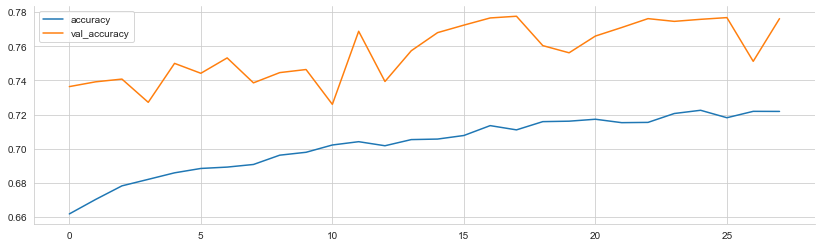

In [52]:
pd.DataFrame(cnn_aug_history.history)[['accuracy',
                                       'val_accuracy']].plot(figsize=(14, 4))
sns.despine();

### Load best model

In [53]:
cnn.load_weights(cnn_aug_path)

### Test set accuracy

The test accuracy for the three-layer CNN improves markedly to 74.79% after training on the larger, augmented data.

In [54]:
cnn_aug_accuracy = cnn.evaluate(X_test, y_test, verbose=0)[1]
print('Test Accuracy: {:.2%}'.format(cnn_aug_accuracy))

Test Accuracy: 76.23%


## AlexNet

We also need to simplify the AlexNet architecture in response to the lower dimensionality of CIFAR10 images relative to the ImageNet samples used in the competition. We use the original number of filters but make them smaller (see notebook for implementation). The summary shows the five convolutional layers followed by two fully-connected layers with frequent use of batch normalization, for a total of 21.5 million parameters:

### Define Architecture

In [55]:
K.clear_session()

In [56]:
alexnet = Sequential([

    # 1st Convolutional Layer
    Conv2D(96, (3, 3),
           strides=(2, 2),
           activation='relu',
           padding='same',
           input_shape=input_shape,
           name='CONV_1'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='POOL_1'),
    BatchNormalization(name='NORM_1'),

    # 2nd Convolutional Layer
    Conv2D(filters=256,
           kernel_size=(5, 5),
           padding='same',
           activation='relu',
           name='CONV2'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='POOL2'),
    BatchNormalization(name='NORM_2'),

    # 3rd Convolutional Layer
    Conv2D(filters=384,
           kernel_size=(3, 3),
           padding='same',
           activation='relu',
           name='CONV3'),
    # 4th Convolutional Layer
    Conv2D(filters=384,
           kernel_size=(3, 3),
           padding='same',
           activation='relu',
           name='CONV4'),
    # 5th Convolutional Layer
    Conv2D(filters=256,
           kernel_size=(3, 3),
           padding='same',
           activation='relu',
           name='CONV5'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='POOL5'),
    BatchNormalization(name='NORM_5'),

    # Fully Connected Layers
    Flatten(name='FLAT'),
    Dense(4096, input_shape=(32 * 32 * 3, ), activation='relu', name='FC1'),
    Dropout(0.4, name='DROP1'),
    Dense(4096, activation='relu', name='FC2'),
    Dropout(0.4, name='DROP2'),
    Dense(num_classes, activation='softmax')
])

In [57]:
alexnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 16, 16, 96)        2688      
_________________________________________________________________
POOL_1 (MaxPooling2D)        (None, 8, 8, 96)          0         
_________________________________________________________________
NORM_1 (BatchNormalization)  (None, 8, 8, 96)          384       
_________________________________________________________________
CONV2 (Conv2D)               (None, 8, 8, 256)         614656    
_________________________________________________________________
POOL2 (MaxPooling2D)         (None, 3, 3, 256)         0         
_________________________________________________________________
NORM_2 (BatchNormalization)  (None, 3, 3, 256)         1024      
_________________________________________________________________
CONV3 (Conv2D)               (None, 3, 3, 384)         8

### Compile Model

In [58]:
alexnet.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

### Define Callbacks

In [59]:
alexnet_path = (results_path / 'alexnet.weights.best.hdf5').as_posix()

In [60]:
checkpointer = ModelCheckpoint(filepath=alexnet_path,
                               verbose=1,
                               monitor='val_accuracy',
                               save_best_only=True)

In [61]:
tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'alexnet',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

In [62]:
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               mode='max',
                               patience=10)

### Train Model

In [63]:
batch_size = 32
epochs = 100

In [64]:
alex_history = alexnet.fit(X_train, 
                           y_train,
                           batch_size=batch_size,
                           epochs=epochs,
                           validation_data=(X_valid, 
                                            y_valid),
                           callbacks=[checkpointer, 
                                      tensorboard, 
                                      early_stopping],
                           verbose=1)

Epoch 1/100
1407/1407 [==============================] - ETA: 0s - loss: 1.6061 - accuracy: 0.4240
Epoch 00001: val_accuracy improved from -inf to 0.55160, saving model to results/cifar10/alexnet.weights.best.hdf5
1407/1407 [==============================] - 27s 19ms/step - loss: 1.6061 - accuracy: 0.4240 - val_loss: 1.2629 - val_accuracy: 0.5516
Epoch 2/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.3583 - accuracy: 0.5207
Epoch 00002: val_accuracy did not improve from 0.55160
1407/1407 [==============================] - 26s 18ms/step - loss: 1.3581 - accuracy: 0.5208 - val_loss: 1.4801 - val_accuracy: 0.4916
Epoch 3/100
1407/1407 [==============================] - ETA: 0s - loss: 1.1069 - accuracy: 0.6126
Epoch 00003: val_accuracy improved from 0.55160 to 0.60020, saving model to results/cifar10/alexnet.weights.best.hdf5
1407/1407 [==============================] - 35s 25ms/step - loss: 1.1069 - accuracy: 0.6126 - val_loss: 1.1564 - val_accuracy: 0.6002
Epoch 4/10

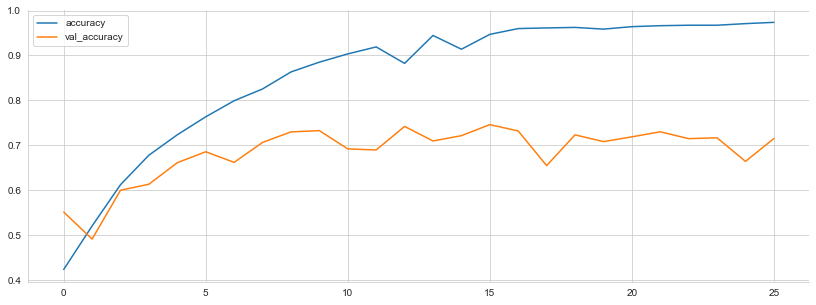

In [65]:
pd.DataFrame(alex_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(14, 5))
sns.despine();

In [66]:
alexnet.load_weights(alexnet_path)

After training for 20 episodes, each of which takes a little under 30 seconds on a single GPU, we obtain 76.84% test accuracy.

In [67]:
alex_accuracy = alexnet.evaluate(X_test, y_test, verbose=0)[1]
print('Test Accuracy: {:.2%}'.format(alex_accuracy))

Test Accuracy: 73.21%


## Compare Results

In [68]:
cv_results = pd.DataFrame(
    {'Feed-Forward NN': pd.Series(mlp_history.history['val_accuracy']),
        'CNN': pd.Series(cnn_history.history['val_accuracy']),
        'CNN Aug.': pd.Series(cnn_aug_history.history['val_accuracy']),
        'Alex Net': pd.Series(alex_history.history['val_accuracy'])
    })

In [69]:
test_accuracy = pd.Series({
    'Feed-Forward NN': mlp_accuracy,
    'CNN': cnn_accuracy,
    'CNN Aug.': cnn_aug_accuracy,
    'Alex Net': alex_accuracy
})

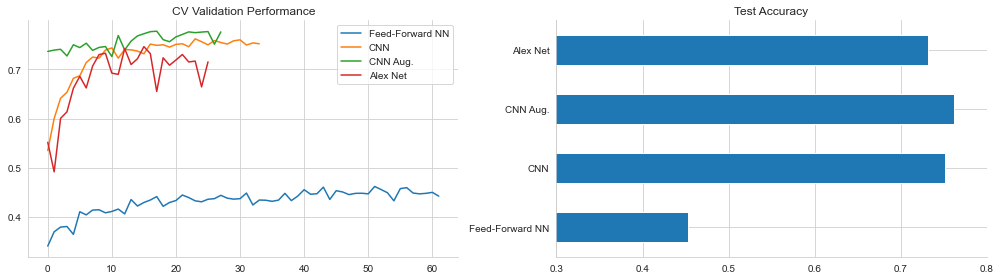

In [70]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
cv_results.plot(ax=axes[0], title='CV Validation Performance')
test_accuracy.plot.barh(ax=axes[1], xlim=(.3, .8), title='Test Accuracy')
fig.tight_layout()
sns.despine()
fig.savefig(results_path / 'comparison', dpi=300);

## TensorBoard visualization

In [71]:
%load_ext tensorboard

In [72]:
%tensorboard --logdir results/cifar10/logs

Reusing TensorBoard on port 6009 (pid 11959), started 4:08:40 ago. (Use '!kill 11959' to kill it.)